In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier    #分类器
from sklearn import cross_validation,metrics #交叉验证、模型评估
from sklearn.grid_search import GridSearchCV #参数选择

import matplotlib.pylab as plt  
%matplotlib inline

from matplotlib.pylab import rcParams   #fea_imp 图像大小
rcParams['figure.figsize']=12,4

In [26]:
train=pd.read_csv('train_gai.csv')
test=pd.read_csv('test_gai.csv')  #test 测试集无标签，没用上

In [27]:
train.shape,test.shape

((87020, 82), (37717, 81))

In [28]:
train.head(2)

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,Var1_0,...,Filled_Form_1,Device_Type_0,Device_Type_1,Mobile_Verified_0,Mobile_Verified_1,Processing_Fee_Missing,Loan_Amount_Submitted_Missing,Loan_Tenure_Submitted_Missing,EMI_Loan_Submitted_Missing,Interest_Rate_Missing
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,39,0,...,0,0,1,1,0,1,1,1,1,1
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,32,0,...,0,0,1,0,1,1,0,0,0,0


In [29]:
test.head(2)

,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,Var1_0,Var1_1,...,Filled_Form_1,Device_Type_0,Device_Type_1,Mobile_Verified_0,Mobile_Verified_1,Processing_Fee_Missing,Loan_Amount_Submitted_Missing,Loan_Tenure_Submitted_Missing,EMI_Loan_Submitted_Missing,Interest_Rate_Missing
0,0.0,ID000026A10,100000.0,3.0,21500,3,3,30,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0.0,ID000054C40,0.0,0.0,42000,5,8,37,0,1,...,1,1,0,0,1,0,0,0,0,0


In [30]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [31]:
target='Disbursed'
IDcol='ID'

#alg 分类器，predictors 特征列表，提前停止

In [ ]:
## Define a function for modeling and cross-validation
This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [32]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    #基于当前参数集合，得到最佳的弱分类器个数'n_estimators'
    if useTrainCV: 
        xgb_param = alg.get_xgb_params()  #将当前变量取出
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)   #构造训练集     
        xgtest = xgb.DMatrix(dtest[predictors].values)                                  #构造测试集合
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)      #进行交叉验证
        print(cvresult.shape[0])   
        alg.set_params(n_estimators=cvresult.shape[0])  #n_estimators 弱分类器个数
    
    #基于分类器算法，对模型进行训练
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
    
    #对训练集合进行预测
    dtrain_predictions = alg.predict(dtrain[predictors])          #输出0，1 
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]  #预测各个样本为1的概率，第0列为0的概率
        
    #输出模型评分结果
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)) #真实与预测比较评估
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)) 
    
    #得到所有弱分类器f得分(AUC，召回率），重要性降序排序
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)    
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

145

Model Report
Accuracy : 0.9855
AUC Score (Train): 0.902977


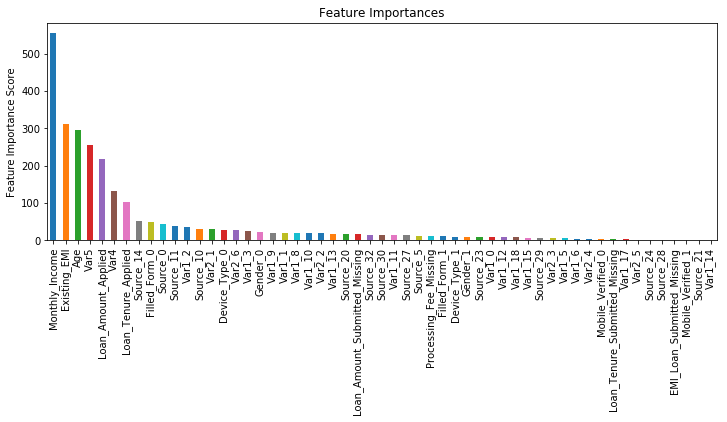

In [33]:
predictors = [x for x in train.columns if x not in [target, IDcol]]  #对所有变量属性选取，除了'Disbursed'和‘ID’；
xgb1 = XGBClassifier(
        learning_rate =0.1,          #学习率eta, 算法训练时，每一步的更新步长
        n_estimators=1000,           #弱分类器的个数
        max_depth=5,                 #树的最大深度
        min_child_weight=1,          #叶子节点中，样本的权重和
        gamma=0,                       #控制训练时每一颗树叶叶子节点，正则项，防过拟合
        subsample=0.8,                 #模型训练子样本占全部集合的比例，防过拟合
        colsample_bytree=0.8,          #构建树时对特征的采样比例
        objective= 'binary:logistic',  #二分类’binary:logistic'；线性回归‘reg:linear'
        nthread=4,                     #计算线程数目
        scale_pos_weight=1,            #正负样本平衡权重         
        seed=27)                       #随机数种子或者random_seed

modelfit(xgb1, train, test, predictors) #当前模型基础上，进行分类器的训练选择

调节参数'max_depth','min_child_weight','gamma','subsample','colsample_bytree','reg_alpha'

In [ ]:
#调参的基本方法
1.Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. 
Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” 
which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2.Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided 
learning rate and number of trees. Note that we can choose different parameters to define a tree.
3.Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance 
performance.
4.Lower the learning rate and decide the optimal parameters.

# 调整'max_depth','min_child_weight'参数，5，1中心

In [45]:
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=145, 
        max_depth=5,                                   
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test1, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch1.fit(train[predictors],train[target])   

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=145, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [46]:
gsearch1.grid_scores_

[mean: 0.84432, std: 0.00614, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.84425, std: 0.00629, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.84374, std: 0.00575, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.84819, std: 0.00675, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.84724, std: 0.00578, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.84690, std: 0.00575, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.84328, std: 0.00543, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.84146, std: 0.00601, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.84107, std: 0.00698, params: {'max_depth': 7, 'min_child_weight': 5},
 mean: 0.83500, std: 0.00661, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: 0.83600, std: 0.00658, params: {'max_depth': 9, 'min_child_weight': 3},
 mean: 0.83644, std: 0.00582, params: {'max_depth': 9, 'min_child_weight': 5}]

In [47]:
gsearch1.best_params_

{'max_depth': 5, 'min_child_weight': 1}

In [48]:
gsearch1.best_score_

0.8481940234847519

# 'max_depth': 5, 'min_child_weight': 1  ，步长大，需缩小范围

In [49]:
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[1,2,3]}
gsearch2 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=145, 
        max_depth=5,                                   
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch2.fit(train[predictors],train[target]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=145, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [51]:
gsearch2.grid_scores_

[mean: 0.84834, std: 0.00563, params: {'max_depth': 4, 'min_child_weight': 1},
 mean: 0.84734, std: 0.00529, params: {'max_depth': 4, 'min_child_weight': 2},
 mean: 0.84710, std: 0.00625, params: {'max_depth': 4, 'min_child_weight': 3},
 mean: 0.84819, std: 0.00675, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.84789, std: 0.00739, params: {'max_depth': 5, 'min_child_weight': 2},
 mean: 0.84724, std: 0.00578, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.84560, std: 0.00590, params: {'max_depth': 6, 'min_child_weight': 1},
 mean: 0.84655, std: 0.00576, params: {'max_depth': 6, 'min_child_weight': 2},
 mean: 0.84568, std: 0.00603, params: {'max_depth': 6, 'min_child_weight': 3}]

In [52]:
gsearch2.best_params_

{'max_depth': 4, 'min_child_weight': 1}

In [53]:
gsearch2.best_score_

0.8483407884065786

# 'max_depth': 4, 'min_child_weight': 1   相对最优，调节gamma

In [55]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]}
gsearch3 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=145, 
        max_depth=4,                                   
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test3, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch3.fit(train[predictors],train[target]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=145, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [56]:
gsearch3.grid_scores_

[mean: 0.84834, std: 0.00563, params: {'gamma': 0.0},
 mean: 0.84847, std: 0.00558, params: {'gamma': 0.1},
 mean: 0.84738, std: 0.00603, params: {'gamma': 0.2},
 mean: 0.84720, std: 0.00593, params: {'gamma': 0.3},
 mean: 0.84753, std: 0.00539, params: {'gamma': 0.4}]

In [57]:
gsearch3.best_params_

{'gamma': 0.1}

In [58]:
gsearch3.best_score_

0.8484704571588637

# 'max_depth': 4,'min_child_weight': 1,'gamma':0.1 相对最优

202

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.898711


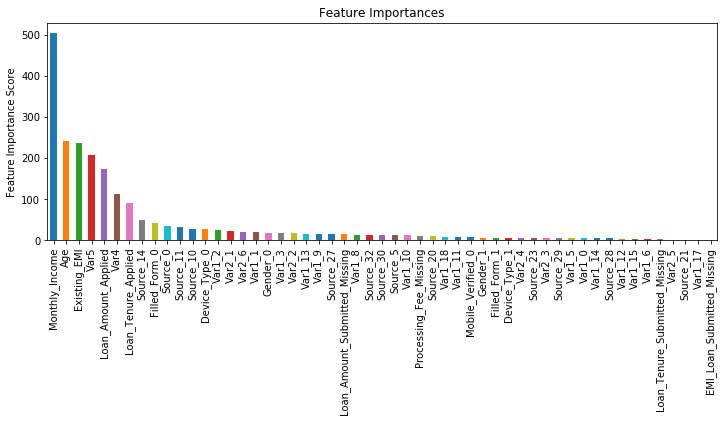

In [59]:
predictors = [x for x in train.columns if x not in [target, IDcol]]  #对所有变量属性选取，除了'Disbursed'和‘ID’；
xgb2 = XGBClassifier(
        learning_rate =0.1,          #学习率eta, 算法训练时，每一步的更新步长
        n_estimators=1000,           #弱分类器的个数
        max_depth=4,                 #树的最大深度
        min_child_weight=1,          #叶子节点中，样本的权重和
        gamma=0.1,                       #控制训练时每一颗树叶叶子节点，正则项，防过拟合
        subsample=0.8,                 #模型训练子样本占全部集合的比例，防过拟合
        colsample_bytree=0.8,          #构建树时对特征的采样比例
        objective= 'binary:logistic',  #二分类’binary:logistic'；线性回归‘reg:linear'
        nthread=4,                     #计算线程数目
        scale_pos_weight=1,            #正负样本平衡权重         
        seed=27)                       #随机数种子或者random_seed

modelfit(xgb2, train, test, predictors) #当前模型基础上，进行分类器的训练选择

#  max_depth=4,min_child_weight=1,gamma=0.1相对最优基础上，调节参数subsample,colsample_bytree

In [61]:
param_test4={
    'subsample': [i/10 for i in range(6,10)],
    'colsample_bytree':[i/10 for i in range(6,10)]}
gsearch4=GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=202, 
        max_depth=4,                                   
        min_child_weight=1, 
        gamma=0.1, 
        subsample=0.8, 
        colsample_bytree=0.8,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test4, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch4.fit(train[predictors],train[target]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=202, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [62]:
gsearch4.grid_scores_

[mean: 0.84500, std: 0.00725, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: 0.84615, std: 0.00538, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: 0.84750, std: 0.00535, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.84901, std: 0.00643, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.84599, std: 0.00770, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mean: 0.84809, std: 0.00597, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
 mean: 0.84807, std: 0.00568, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
 mean: 0.84824, std: 0.00601, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
 mean: 0.84608, std: 0.00680, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
 mean: 0.84761, std: 0.00624, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
 mean: 0.84899, std: 0.00629, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
 mean: 0.84787, std: 0.00600, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
 mea

In [63]:
gsearch4.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.9}

In [65]:
gsearch4.best_score_

0.8490100983567583

# 继续调节参数subsample,colsample_bytree

In [72]:
param_test5={
    'colsample_bytree':[i/100 for i in range(50,70,5)],
    'subsample':[i/100 for i in range(80,100,5)]}
gsearch5=GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=202, 
        max_depth=4,                                   
        min_child_weight=1, 
        gamma=0.1, 
        subsample=0.9, 
        colsample_bytree=0.6,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test5, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch5.fit(train[predictors],train[target]) 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=202, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.5, 0.55, 0.6, 0.65], 'subsample': [0.8, 0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [73]:
gsearch5.grid_scores_

[mean: 0.84663, std: 0.00624, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
 mean: 0.84778, std: 0.00547, params: {'colsample_bytree': 0.5, 'subsample': 0.85},
 mean: 0.84827, std: 0.00649, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
 mean: 0.84814, std: 0.00708, params: {'colsample_bytree': 0.5, 'subsample': 0.95},
 mean: 0.84770, std: 0.00628, params: {'colsample_bytree': 0.55, 'subsample': 0.8},
 mean: 0.84706, std: 0.00738, params: {'colsample_bytree': 0.55, 'subsample': 0.85},
 mean: 0.84709, std: 0.00627, params: {'colsample_bytree': 0.55, 'subsample': 0.9},
 mean: 0.84913, std: 0.00583, params: {'colsample_bytree': 0.55, 'subsample': 0.95},
 mean: 0.84750, std: 0.00535, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.84726, std: 0.00724, params: {'colsample_bytree': 0.6, 'subsample': 0.85},
 mean: 0.84901, std: 0.00643, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.84913, std: 0.00578, params: {'colsample_bytree': 0.6, 'subsample': 0

In [74]:
gsearch5.best_params_

{'colsample_bytree': 0.65, 'subsample': 0.9}

In [75]:
gsearch5.best_score_

0.8496748021842248

# 'subsample'=0.9,'colsample'=0.65,相对最优，继续调'reg_alpha'

In [76]:
param_test6={
    'reg_alpha':[1e-5,1e-2,1e-1,1,100]}  #L1范数
gsearch6=GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=202, 
        max_depth=4,                                   
        min_child_weight=1, 
        gamma=0.1, 
        subsample=0.9, 
        colsample_bytree=0.65,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test6, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=202, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [77]:
gsearch6.grid_scores_

[mean: 0.84967, std: 0.00670, params: {'reg_alpha': 1e-05},
 mean: 0.84980, std: 0.00539, params: {'reg_alpha': 0.01},
 mean: 0.84967, std: 0.00615, params: {'reg_alpha': 0.1},
 mean: 0.84939, std: 0.00735, params: {'reg_alpha': 1},
 mean: 0.81621, std: 0.01418, params: {'reg_alpha': 100}]

In [79]:
gsearch6.best_params_

{'reg_alpha': 0.01}

In [80]:
gsearch6.best_score_

0.8498045892464328

# 'reg_alpha'=0.01,缩小范围继续调优

In [81]:
param_test7={
    'reg_alpha':[0,0.001,0.005,0.01]}
gsearch7=GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1, 
        n_estimators=202, 
        max_depth=4,                                   
        min_child_weight=1, 
        gamma=0.1, 
        subsample=0.9, 
        colsample_bytree=0.65,                                   
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27
    ), 
    param_grid = param_test7, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch7.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.65,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=202, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [82]:
gsearch7.grid_scores_

[mean: 0.84967, std: 0.00670, params: {'reg_alpha': 0},
 mean: 0.84887, std: 0.00639, params: {'reg_alpha': 0.001},
 mean: 0.84957, std: 0.00547, params: {'reg_alpha': 0.005},
 mean: 0.84980, std: 0.00539, params: {'reg_alpha': 0.01}]

In [83]:
gsearch7.best_params_

{'reg_alpha': 0.01}

In [84]:
gsearch7.best_score_

0.8498045892464328

# 参数相对最优
'max_depth'=4,'min_child_weight'=1,'gamma'=0.1,
'subsample'=0.9,'colsample_bytree'=0.65,'reg_alpha'=0.01

226

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.897460


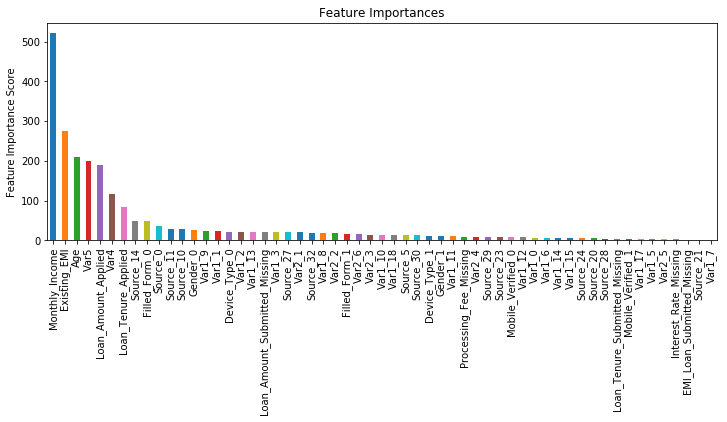

In [85]:
predictors = [x for x in train.columns if x not in [target, IDcol]]  #对所有变量属性选取，除了'Disbursed'和‘ID’；
xgb3 = XGBClassifier(
        learning_rate =0.1,          #学习率eta, 算法训练时，每一步的更新步长
        n_estimators=1000,           #弱分类器的个数
        max_depth=4,                 #树的最大深度
        min_child_weight=1,          #叶子节点中，样本的权重和
        reg_alpha=0.01,
        gamma=0.1,                       #控制训练时每一颗树叶叶子节点，正则项，防过拟合
        subsample=0.9,                 #模型训练子样本占全部集合的比例，防过拟合
        colsample_bytree=0.65,          #构建树时对特征的采样比例
        objective= 'binary:logistic',  #二分类’binary:logistic'；线性回归‘reg:linear'
        nthread=4,                     #计算线程数目
        scale_pos_weight=1,            #正负样本平衡权重         
        seed=27)                       #随机数种子或者random_seed

modelfit(xgb3, train, test, predictors) #当前模型基础上，进行分类器的训练选择

# 调小学习率eta,继续训练

2294

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896949


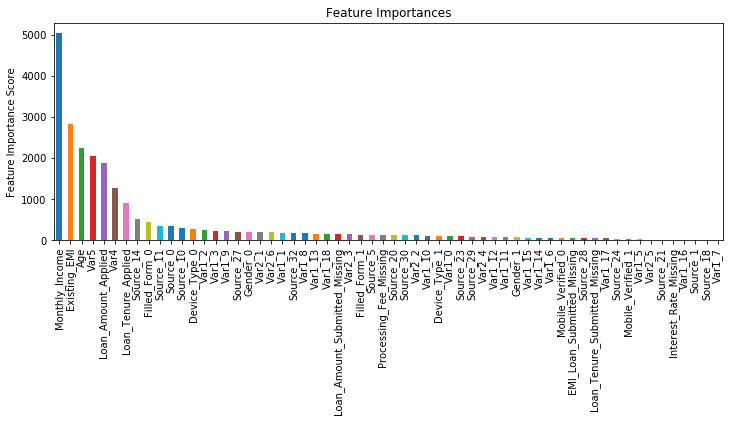

In [86]:
predictors = [x for x in train.columns if x not in [target, IDcol]]  #对所有变量属性选取，除了'Disbursed'和‘ID’；
xgb4 = XGBClassifier(
        learning_rate =0.01,          #学习率eta, 算法训练时，每一步的更新步长
        n_estimators=5000,           #弱分类器的个数
        max_depth=4,                 #树的最大深度
        min_child_weight=1,          #叶子节点中，样本的权重和
        reg_alpha=0.01,
        gamma=0.1,                       #控制训练时每一颗树叶叶子节点，正则项，防过拟合
        subsample=0.9,                 #模型训练子样本占全部集合的比例，防过拟合
        colsample_bytree=0.65,          #构建树时对特征的采样比例
        objective= 'binary:logistic',  #二分类’binary:logistic'；线性回归‘reg:linear'
        nthread=4,                     #计算线程数目
        scale_pos_weight=1,            #正负样本平衡权重         
        seed=27)                       #随机数种子或者random_seed

modelfit(xgb4, train, test, predictors) #当前模型基础上，进行分类器的训练选择

In [ ]:
'''
import xgboost as xgb
#定义xgboost算法的参数函数
def pipeline(iteration,random_seed,gamma,max_depth,lambd,subsample,
             colsample_bytree,min_child_weight):
    #将数据转化为xgb算法数据格式
    dtest=xgb.DMatrix(tests)        #测试集、训练集、va验证集
    dtrain=xgb.DMatrix(X,label=y)   
    dval=xgb.DMatrix(va,label=valy)
    params={
        'booster':'gbtree', #基于树的booster模型
        'objective':'reg:linear',#线性回归‘reg:linear';二分类’binary:logistic'
        'gamma':gamma,           #控制算法训练时每一颗树叶叶子节点
        'max_depth':max_depth,   #树的最大深度
        'lambda':lambd,          #L2正则化系数
        'subsample':subsample,   #训练模型的子样本占整个集合的比例，防止过拟合
        'colsample_bytree':colsample_bytree, #构建树时对特征的采样比例
        'min_child_weight':min_child_weight, #叶子节点中，样本的权重和
        'eta':0.2,           #学习率，算法训练过程中，每一步的更新步长
        'seed':random_seed,  #随机数种子
    }
    
    watchlist = [(dtrain,'train'),(dval,'val')]
    num_round = 6560  #算法迭代总次数
    model =xgb.train(params,dtrain,num_round,watchlist)    #模型训练
    test_y =model.predit(dtest,ntree_limit=model.best_ntree_limit)#模型预
'''